# CSC 215 Final Project
# Amit Kulkarni  Ninad Jadhav


# Web Genre Classification using Naive Bayes and Text Transfer Learning through Glove and Custom built WF-257 based only on URLs of website.



In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random

import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [270]:
import requests
from bs4 import BeautifulSoup
import csv

# Web Scraping to obtain contents from websites

In [274]:
import os
path = 'C:/Users/Amit/Desktop/'
fn = 'urlset.csv'
fn1 ='urlsetoutput.csv'

# this is  web scraping module demo. This module was used several times on several files to obtain the final URL_Data.csv
with open(os.path.join(path, fn)) as f_urls, open(os.path.join(path, fn1), 'w', newline='',encoding="utf-8") as f_output:
    csv_urls = csv.reader(f_urls)
    csv_output = csv.writer(f_output)
    csv_output.writerow(['Title','Content','MetaDesc','Meta keywords','HREF Label'])
    
    none='no title'
    for line in csv_urls:
        headers = {'User-Agent': 'Mozilla/5.0'}
        print("Line 2 is",line[1])
        r = requests.get(line[1],headers=headers).text
        soup = BeautifulSoup(r, 'html.parser')
        title = soup.find('title')
        if(title==None):
            title=none
        else:
            print('Title:', title.text)
        
        content = soup.find('p')
        if(content==None):
            content=title
            print('Content:',content)
        else:
            paragraphs = ''
            for x in content:
                paragraphs+=str(x)
                paragraphs=paragraphs[0:55].strip()
                content=paragraphs
            print('Content:',paragraphs)
        metas = soup.find_all('meta')
        meta=''
        if (metas==None):
            meta=title
        else:
            for meta1 in metas:
                if ('name' in meta1.attrs and meta1.attrs['name'] == 'description'):
                    meta = meta1.attrs['content']
                    
            for meta2 in metas:
                if ('name' in meta2.attrs and meta2.attrs['name'] == 'keywords'):
                    meta = meta2.attrs['content']
                   
        anchor = soup.find('a')
        atag = ''
        if(anchor==None):
            atag='none'
        else:
            for x in anchor:
                atag+=str(x)
                atag=atag[0:55].strip() 
        print("HREF Label:",atag)
        csv_output.writerow([title, content,meta ,meta,atag])

Line 2 is https://cscar.research.umich.edu/
Title:   CSCAR
Content: OVERVIEW This workshop will provide a brief overview of
HREF Label: Skip to main content
Line 2 is https://cla.umn.edu/statistics
Title: School of Statistics | Statistics | College of Liberal Arts | University of Minnesota
Content: Our world is governed by knowledge gained through stati
HREF Label: Skip to main navigation
Line 2 is https://www.sph.umn.edu/academics/divisions/biostatistics/
Title: Biostatistics - Academic Divisions - School of Public Health - University of Minnesota
Content: <span class="lede">The Division of Biostatistics focuse
HREF Label: Main navigation
Line 2 is https://www.stat.missouri.edu/
Title: Statistics
Content: <a href="https://missouri.edu">Mizzou Logo</a>
HREF Label: Skip to main content
Line 2 is https://statistics.unl.edu/
Title: Department of Statistics | Nebraska
Content: <span style="color:#d00000;">Statistics</span> as a dis
HREF Label: Skip to main content
Line 2 is http://stat.unm

Title: Department of Mathematics
Content: We do active research in
algebra,
analysis,
approximati
HREF Label: <div class="header__svg-wrapper-main">
<svg version="1.
Line 2 is https://www.unb.ca/fredericton/science/undergrad/options/mathematics/index.html
Title: Faculty of Science | Mathematics and Statistics | UNB
Content: <img alt="Mathematics" class="imageright" src="../../..
HREF Label: Skip to Main Content
Line 2 is https://www.unbc.ca/math-statistics
Title: Department of Mathematics and Statistics | University of Northern British Columbia
Content: <a class="element-invisible element-focusable" href="#m
HREF Label: Jump to navigation
Line 2 is https://science.uottawa.ca/mathstat/en
Title: Home | Department of Mathematics and Statistics | University of Ottawa
Content: A very involved and knowledgeable group of 44 talented<
HREF Label: Jump to Main Content
Line 2 is https://www.upei.ca/programs/mathematics
Title: Mathematics | University of Prince Edward Island
Content: Mathematics 

# Data- PreProcessing

In [3]:
dataset=pd.read_csv('C:\\Users\\Amit\\Desktop\\URL_Data.csv')

In [4]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

# Clean text function to remove stopwords given in paper and to remove special charaters and numbers.

In [19]:
def clean_text(text):
    text = text.lower()
    #removing stopwords provided in paper
    text = re.sub(r"what", " ", text)
    text = re.sub(r"Information", " ", text)
    text = re.sub(r"login", " ", text)
    text = re.sub(r"web", " ",text)
    text = re.sub(r"online", " ",text)
    text = re.sub(r"search", " ",text)
    text = re.sub(r"keyword", " ",text)
    text = re.sub("copyright"," ",text)
    text = re.sub("rights"," ",text)
    text = re.sub("reserved", " ",text)
    text = re.sub("click", " ",text)
    text = re.sub( "website"," ",text)
    text = re.sub( "designed"," ",text)
    text = re.sub("search"," ",text)
    text = re.sub("click"," ",text)
    text = re.sub("welcome", " ", text)
    text = re.sub("email", " ", text)
    text = re.sub("click"," ", text)
    text = re.sub("contact"," ", text)
    text = re.sub("mail"," ", text)
    text = re.sub("home"," ", text)
    text = re.sub("page"," ", text)
    text = re.sub("feedback"," ", text)
    #removing common english stopwords provided by nltk
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    text = re.sub('\W', ' ', text)#remove nonword chars
    text = re.sub('\s+', ' ', text)# removing multiple spaces
    text = re.sub(r"[^A-Za-z]", " ", text)
    text = re.sub(r"\'s", " ", text)
    
    text = text.strip(' ')
    return text

# Word Stemming

In [20]:
from nltk.stem import PorterStemmer

def stem(text):
    text=str(text)
    text = text.split()
    stemmer =  PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

# Implementing Naive Bayes from paper

In [269]:
dataset['Content'] = dataset['Content']+dataset['Title']+dataset['MetaDesc'] + dataset['Meta keywords']+dataset['HREF Label']

In [22]:
dataset['Content'] =dataset['Content'].astype(str)

In [23]:
dataset['Content'] = dataset['Content'].map(lambda rec : clean_text(rec))

In [24]:
dataset['Content'] = dataset['Content'].map(lambda rec : stem(rec))

In [25]:
X= dataset['Content']

In [26]:
y = dataset['Category']

In [27]:
from sklearn import preprocessing, metrics, naive_bayes, pipeline,feature_extraction 
le = preprocessing.LabelEncoder()
le.fit(dataset.Category)

y_data = le.transform(dataset.Category)

In [28]:
X_data = dataset.Content.values

In [29]:
import operator
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

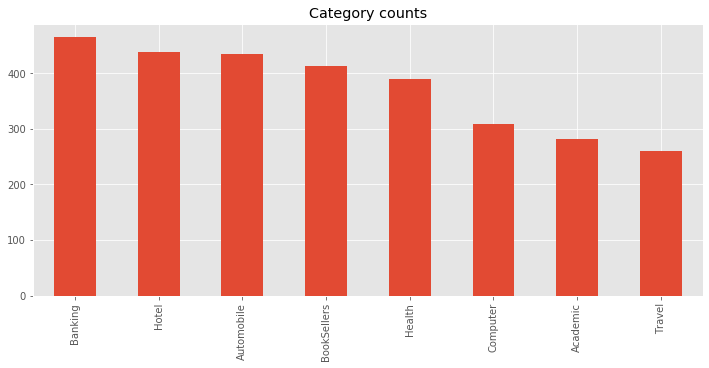

In [30]:
plt.figure(figsize=(12, 5))
dataset.Category.value_counts().plot(kind='bar');
plt.title('Category counts');

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [44]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

In [45]:
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [46]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

In [47]:
my_cat=['Academic','Automobile','Banking', 'BookSellers',
       'Computer','Health','Hotel', 'Travel']

In [41]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_cat))

accuracy 0.42538975501113585
              precision    recall  f1-score   support

    Academic       0.85      0.52      0.64        97
  Automobile       0.36      0.58      0.44       129
     Banking       0.36      0.79      0.49       130
 BookSellers       0.36      0.38      0.37       115
    Computer       0.50      0.08      0.14        96
      Health       0.36      0.23      0.28       107
       Hotel       0.53      0.42      0.47       139
      Travel       0.82      0.21      0.34        85

    accuracy                           0.43       898
   macro avg       0.52      0.40      0.40       898
weighted avg       0.50      0.43      0.41       898



# Naive Bayes On Only Four Categories

In [49]:
df=pd.read_csv('C:\\Users\\Amit\\Desktop\\Final_URL_Category.csv')

In [50]:
df['Content'] =df['Content'].astype(str)
df['Content'] = df['Content'].map(lambda com : clean_text(com))
df['Content'] = df['Content'].map(lambda rec : stem(rec))
X= df['Content']
y = df['Category']


from sklearn import preprocessing, metrics, naive_bayes, pipeline,feature_extraction 
le = preprocessing.LabelEncoder()
le.fit(df.Category)

y_data = le.transform(df.Category)
X_data = df.Content.values


In [51]:
import operator
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

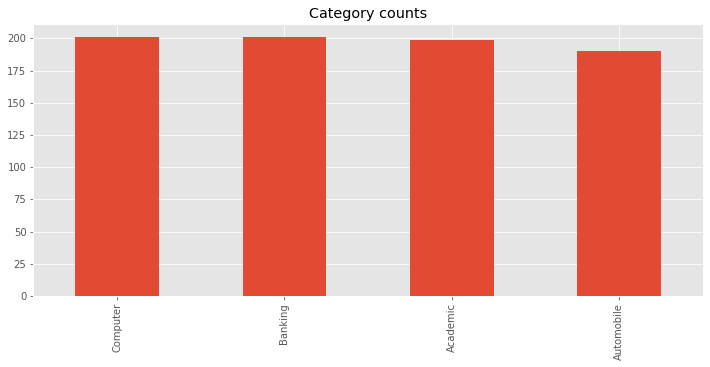

In [52]:
plt.figure(figsize=(12, 5))
df.Category.value_counts().plot(kind='bar');
plt.title('Category counts');

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 41)

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])



In [79]:
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [80]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

In [81]:
my_cat=['Banking','Computer','Academic','Automobile']

In [76]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_cat))

accuracy 0.5504201680672269
              precision    recall  f1-score   support

     Banking       0.71      0.77      0.74        61
    Computer       0.47      0.31      0.38        58
    Academic       0.48      0.70      0.57        57
  Automobile       0.52      0.42      0.46        62

    accuracy                           0.55       238
   macro avg       0.55      0.55      0.54       238
weighted avg       0.55      0.55      0.54       238



# Transfer Learning on text through Glove and using custom WF-257 Algorithm

# Glove

In [259]:
f = open('C:\\Users\\Amit\\Desktop\glove.6B.100d.txt',encoding='utf-8')

In [260]:
text = f.readlines()

In [261]:
wordlist = [line.strip().split()[0] for line in text]

In [262]:
vocab_size = 20000
seq_len = 200
from collections import Counter

In [263]:
word_to_count = Counter(wordlist).most_common(vocab_size)

In [264]:
len(word_to_count)

20000

In [266]:
word_to_count = {x[0]:i for i, x in enumerate(word_to_count)}

In [268]:
word_to_count

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [179]:
train = [np.array([word_to_count[y] if y in word_to_count else vocab_size-1 for y in x]) for x in text]

In [180]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.layers import Embedding

In [181]:
train = pad_sequences(train, maxlen=seq_len, value=0)

In [182]:
train.shape

(400000, 200)

In [95]:
train = train.astype('float32')

In [183]:
from tensorflow.keras.utils import to_categorical

In [184]:
from sklearn import preprocessing, metrics, naive_bayes, pipeline,feature_extraction

In [185]:
le = preprocessing.LabelEncoder()
le.fit(df.Category)

LabelEncoder()

In [186]:
X_data = df.Content.values

In [187]:
y_data = le.transform(df.Category)

In [188]:
X_data.shape

(791,)

In [189]:
y_data.shape

(791,)

In [190]:
from sklearn.model_selection import train_test_split

In [191]:
y_data = to_categorical(y_data)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(train[:791], y_data, \
        test_size=0.2, random_state=2000)

In [214]:
from tensorflow.keras.layers import Convolution1D

In [215]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda

In [216]:
from tensorflow.keras.optimizers import Adam

# Glove with CNN

In [217]:
model = Sequential([
        Embedding(vocab_size, 50, input_length=seq_len),
        Dropout(0.1),
        Convolution1D(64, 5, activation='relu'),
        Dropout(0.2),
        Convolution1D(128, 5,activation='relu'),
        Dropout(0.2),
        MaxPooling1D(),
        Flatten(),
        Dense(200, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer=Adam(), \
        metrics=['accuracy'])

In [218]:
model.optimizer.lr = 1e-4

In [226]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=64)

W1121 22:05:18.470777 11304 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 632 samples, validate on 159 samples
Epoch 1/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1741 - acc: 0.9351 - val_loss: 1.4904 - val_acc: 0.5283
Epoch 2/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1700 - acc: 0.9320 - val_loss: 1.4451 - val_acc: 0.5472
Epoch 3/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1805 - acc: 0.9320 - val_loss: 1.4913 - val_acc: 0.5346
Epoch 4/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1652 - acc: 0.9415 - val_loss: 1.4483 - val_acc: 0.5409
Epoch 5/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1761 - acc: 0.9399 - val_loss: 1.4686 - val_acc: 0.5283
Epoch 6/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1641 - acc: 0.9415 - val_loss: 1.4738 - val_acc: 0.5472
Epoch 7/10
632/632 [==============================] - 2s 3ms/sample - loss: 0.1539 - acc: 0.9351 - val_loss: 1.4816 - val_acc: 0.5409
Epoch 8/10
632/6

In [227]:
preds = [np.argmax(x) for x in model.predict(X_test)]
y_test_argmax = [np.argmax(x) for x in y_test]
print(metrics.classification_report(preds, y_test_argmax, target_names=le.classes_))

              precision    recall  f1-score   support

    Academic       0.66      0.62      0.64        40
  Automobile       0.42      0.37      0.40        46
     Banking       0.68      0.64      0.66        44
    Computer       0.38      0.52      0.43        29

    accuracy                           0.53       159
   macro avg       0.54      0.54      0.53       159
weighted avg       0.55      0.53      0.54       159



# Glove with  LSTM

In [119]:
from tensorflow.keras.layers import SpatialDropout1D

In [122]:
mode2 = Sequential([
        Embedding(vocab_size, 50, input_length=seq_len),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(4, activation='softmax')])
mode2.compile(loss='categorical_crossentropy', optimizer=Adam(), \
        metrics=['accuracy'])

In [232]:
history1=model1.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=64)

W1121 22:29:25.839931 11304 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 632 samples, validate on 159 samples
Epoch 1/15
632/632 [==============================] - 8s 12ms/sample - loss: 0.3194 - acc: 0.9256 - val_loss: 0.9981 - val_acc: 0.5975
Epoch 2/15
632/632 [==============================] - 7s 11ms/sample - loss: 0.2772 - acc: 0.9241 - val_loss: 1.0186 - val_acc: 0.5912
Epoch 3/15
632/632 [==============================] - 7s 12ms/sample - loss: 0.2410 - acc: 0.9367 - val_loss: 1.0510 - val_acc: 0.5786
Epoch 4/15
632/632 [==============================] - 7s 11ms/sample - loss: 0.2612 - acc: 0.9241 - val_loss: 1.0634 - val_acc: 0.5849
Epoch 5/15
632/632 [==============================] - 8s 13ms/sample - loss: 0.2184 - acc: 0.9241 - val_loss: 1.0539 - val_acc: 0.5597
Epoch 6/15
632/632 [==============================] - 7s 12ms/sample - loss: 0.2160 - acc: 0.9288 - val_loss: 1.0657 - val_acc: 0.5535
Epoch 7/15
632/632 [==============================] - 7s 11ms/sample - loss: 0.2006 - acc: 0.9288 - val_loss: 1.0792 - val_acc: 0.5472
Epoch 8/1

In [233]:
preds = [np.argmax(x) for x in model1.predict(X_test)]
y_test_argmax = [np.argmax(x) for x in y_test]
print(metrics.classification_report(preds, y_test_argmax, target_names=le.classes_))

              precision    recall  f1-score   support

    Academic       0.66      0.76      0.70        33
  Automobile       0.30      0.60      0.40        20
     Banking       0.80      0.65      0.72        51
    Computer       0.55      0.40      0.46        55

    accuracy                           0.58       159
   macro avg       0.58      0.60      0.57       159
weighted avg       0.62      0.58      0.59       159



# Custom WF-257 model based on word vectors from current dataset

In [275]:
words = [re.findall('[\w]+', x) for x in df.Content]

In [276]:
allwords = []
for x in words:
    allwords += x

In [277]:
word_to_count = Counter(allwords).most_common(vocab_size)

In [278]:
word_to_count[:10]

[('title', 253),
 ('a', 155),
 ('href', 108),
 ('class', 101),
 ('span', 90),
 ('com', 69),
 ('p', 56),
 ('s', 42),
 ('strong', 41),
 ('www', 38)]

In [279]:
word_to_count = {x[0]:i for i, x in enumerate(word_to_count)}

In [280]:
train = [np.array([word_to_count[y] if y in word_to_count else vocab_size-1 for y in x]) for x in words]

In [281]:
train = pad_sequences(train, maxlen=seq_len, value=0)

In [282]:
train = train.astype('float32')

In [283]:
from tensorflow.keras.utils import to_categorical

In [284]:
from sklearn import preprocessing, metrics, naive_bayes, pipeline,feature_extraction

In [291]:
X_data = df.Content.values

In [292]:
y_data = le.transform(df.Category)

In [293]:
y_data = to_categorical(y_data)

In [312]:
X_train, X_test, y_train, y_test = train_test_split(train, y_data, test_size=0.2, random_state=500)

In [143]:
from tensorflow.keras.layers import Convolution1D

In [144]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda

# Custom WF-257 with CNN

In [145]:
newmodel = Sequential([
        Embedding(vocab_size, 50, input_length=seq_len),
        Dropout(0.1),
        Convolution1D(64, 5, activation='relu'),
        Dropout(0.2),
        Convolution1D(128, 5,activation='relu'),
        Dropout(0.2),
        MaxPooling1D(),
        Flatten(),
        Dense(200, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')])
newmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), \
        metrics=['accuracy'])

In [146]:
newmodel.optimizer.lr = 1e-4

In [172]:
newmodel.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=64)

W1124 16:45:27.694390 12792 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 632 samples, validate on 159 samples
Epoch 1/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1713 - acc: 0.9241 - val_loss: 1.3972 - val_acc: 0.5660
Epoch 2/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1697 - acc: 0.9225 - val_loss: 1.3706 - val_acc: 0.5660
Epoch 3/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1622 - acc: 0.9399 - val_loss: 1.3812 - val_acc: 0.5786
Epoch 4/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1622 - acc: 0.9288 - val_loss: 1.3968 - val_acc: 0.5597
Epoch 5/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1690 - acc: 0.9272 - val_loss: 1.3811 - val_acc: 0.5723
Epoch 6/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1772 - acc: 0.9304 - val_loss: 1.3875 - val_acc: 0.5660
Epoch 7/15
632/632 [==============================] - 2s 4ms/sample - loss: 0.1566 - acc: 0.9351 - val_loss: 1.4056 - val_acc: 0.5597
Epoch 8/15
632/6

In [173]:
preds = [np.argmax(x) for x in newmodel.predict(X_test)]
y_test_argmax = [np.argmax(x) for x in y_test]

In [165]:
print (metrics.classification_report(preds, y_test_argmax, target_names=le.classes_))

              precision    recall  f1-score   support

    Academic       0.71      0.71      0.71        38
  Automobile       0.68      0.50      0.57        54
     Banking       0.63      0.67      0.65        39
    Computer       0.35      0.50      0.41        28

    accuracy                           0.59       159
   macro avg       0.59      0.59      0.59       159
weighted avg       0.62      0.59      0.60       159



In [289]:
from tensorflow.keras.layers import SpatialDropout1D

# Best Model

# Custom WF-257 with LSTM

In [290]:
mode257 = Sequential([
        Embedding(vocab_size, 50, input_length=seq_len),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(4, activation='softmax')])
mode257.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [313]:
history3=mode257.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=64)

W1124 23:56:46.097916 12792 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 632 samples, validate on 159 samples
Epoch 1/15
632/632 [==============================] - 9s 14ms/sample - loss: 0.3260 - acc: 0.8797 - val_loss: 0.3182 - val_acc: 0.8742
Epoch 2/15
632/632 [==============================] - 8s 13ms/sample - loss: 0.2416 - acc: 0.9114 - val_loss: 0.3166 - val_acc: 0.8805
Epoch 3/15
632/632 [==============================] - 8s 13ms/sample - loss: 0.1899 - acc: 0.9177 - val_loss: 0.3105 - val_acc: 0.8805
Epoch 4/15
632/632 [==============================] - 8s 13ms/sample - loss: 0.1629 - acc: 0.9304 - val_loss: 0.3183 - val_acc: 0.8742
Epoch 5/15
632/632 [==============================] - 8s 13ms/sample - loss: 0.1550 - acc: 0.9304 - val_loss: 0.3198 - val_acc: 0.8742
Epoch 6/15
632/632 [==============================] - 9s 13ms/sample - loss: 0.1467 - acc: 0.9335 - val_loss: 0.3218 - val_acc: 0.8679
Epoch 7/15
632/632 [==============================] - 9s 14ms/sample - loss: 0.1350 - acc: 0.9415 - val_loss: 0.3286 - val_acc: 0.8679
Epoch 8/1

In [314]:
predslast = [np.argmax(x) for x in mode257.predict(X_test)]
y_test_argmax = [np.argmax(x) for x in y_test]

In [324]:
print('accuracy %s' % accuracy_score(predslast, y_test_argmax))

accuracy 0.8679245283018868


In [315]:
print (metrics.classification_report(predslast, y_test_argmax, target_names=le.classes_))

              precision    recall  f1-score   support

    Academic       0.92      0.97      0.95        37
  Automobile       0.87      0.84      0.85        31
     Banking       0.84      0.90      0.87        40
    Computer       0.85      0.78      0.82        51

    accuracy                           0.87       159
   macro avg       0.87      0.87      0.87       159
weighted avg       0.87      0.87      0.87       159

